<a href="https://colab.research.google.com/github/AraiKensuke/AIiRPS/blob/master/LASSO_AQshort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting AQ-Short and its subfactors**


# Get code from Github
This notebook is largely the same as RPS_AQ28corr.py    if you want to run it from command line locally.

In [1]:
#########  clone and install necessary packages from github repositories

import sys
import importlib

if importlib.util.find_spec("AIiRPS") is None:
  !git clone https://github.com/AraiKensuke/AIiRPS.git

sys.path.insert(1, "/content/AIiRPS")


Cloning into 'AIiRPS'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 355 (delta 189), reused 219 (delta 93), pack-reused 0
Receiving objects: 100% (355/355), 5.62 MiB | 10.66 MiB/s, done.
Resolving deltas: 100% (189/189), done.


# Some functions

Functions that attempt to do somethings about outliers.

In [3]:
import numpy as _N
import matplotlib.pyplot as _plt
import scipy.stats as _ss
from sklearn import linear_model
import sklearn.linear_model as _skl
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import LassoCV


def depickle(s):
     import pickle
     with open(s, "rb") as f:
          lm = pickle.load(f)
     return lm

lm = depickle("/content/AIiRPS/predictAQ28dat/AQ28_vs_RPS.dmp")

AQ28scores = ["AQ28scrs", "soc_skils", "imag", "rout", "switch", "fact_pat"]
AQ28scores_ab = ["AQ28", "SS", "IM", "RT", "SW", "FP"]

outcomes = ["netwins",
            "win_aft_win", "tie_aft_win", "los_aft_win",            
            "win_aft_tie", "tie_aft_tie", "los_aft_tie",
            "win_aft_los", "tie_aft_los", "los_aft_los",
            "u_or_d_tie", "u_or_d_res", "stay_tie", "stay_res"]
outcome_ab = ["NW",
              "WW", "TW", "LW",
              "WT", "TT", "LT",
              "WL", "TL", "LL",
              "T", "W"]  #  0.5 3.5 6.5 9.5


rule_change_features = ["pfrm_change36", "pfrm_change69", "pfrm_change912", "moresim"]

features = ["entropyT2", "entropyW2", "entropyL2", "entropyU", "entropyS", "entropyD",
            "isis_corr", "isis_lv", "entropyL", "entropyT", "entropyW"]
#            "pfrm_change36", "pfrm_change69", "pfrm_change912"]

for feat in features:
    #exec("%(f)s = lm[\"AQ28_%(f)s\"][:, 1]" % {"f" : feat})
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : feat})
    exec("%(f)s = %(f)s / _N.std(%(f)s)" % {"f" : feat})
    exec("%(f)s = %(f)s - _N.mean(%(f)s)" % {"f" : feat})
for outc in outcomes:
    #exec("%(f)s = lm[\"AQ28_%(f)s\"][:, 1]" % {"f" : outc})
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : outc})
    exec("%(f)s = %(f)s / _N.std(%(f)s)" % {"f" : outc})
    exec("%(f)s = %(f)s - _N.mean(%(f)s)" % {"f" : outc})
for scrs in AQ28scores:
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : scrs})
    exec("%(f)s = %(f)s / _N.std(%(f)s)" % {"f" : scrs})
    exec("%(f)s = %(f)s - _N.mean(%(f)s)" % {"f" : scrs})
for rcf in rule_change_features:
    #exec("%(f)s = lm[\"AQ28_%(f)s\"][:, 1]" % {"f" : rcf})
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : rcf})
    exec("%(f)s = %(f)s / _N.std(%(f)s)" % {"f" : rcf})
    exec("%(f)s = %(f)s - _N.mean(%(f)s)" % {"f" : rcf})
#Xs_train = Xs_train / _N.std(Xs_train, axis=0)

all_features = features + outcomes + rule_change_features
X            = _N.empty((AQ28scrs.shape[0], len(all_features)))
iaf = -1
for af in all_features:
    iaf += 1
    exec("feat = %s" % af)
    X[:, iaf] = feat

# targets    = ["SB:SW", "SB:IM", "SB:SS", "AQ28"]
# #targets    = ["Switch", "Imag", "Soc_skils", "AQ28"]
# #targets    = ["Soc_skils"]
# #targets    = ["Imag"]
# #targets    = ["Switch"]
# reps       = 40
# #AQ28scrs = soc_skils + imag + switch

# allscores  = _N.empty((4, reps))

# ths = _N.arange(AQ28scrs.shape[0], dtype=_N.int)
# trainSz = 60
# partitions = 100
# all_trainingInds = _N.empty((partitions, trainSz), dtype=_N.int)
# #  For each shuffle,

# ti = -1
# #fig = _plt.figure(figsize=(3, 5))
# fig = _plt.figure(figsize=(6, 2.5))

scrs = _N.empty(100)
for i in range(100):
    y    = switch
    nrep = 1
    rkf = RepeatedKFold(n_splits=4, n_repeats=nrep)#, random_state=0)
    reg = LassoCV(cv=rkf, max_iter=3000).fit(X, y)
    scrs[i] = reg.score(X, y)


In [4]:
scrs

array([0.12421405, 0.1386486 , 0.13193449, 0.12421405, 0.1386486 ,
       0.15146118, 0.10823674, 0.13193449, 0.14533264, 0.16280111,
       0.15717052, 0.14533264, 0.10074455, 0.10823674, 0.        ,
       0.08261094, 0.13193449, 0.15717052, 0.10823674, 0.1386486 ,
       0.17636873, 0.1719553 , 0.16769787, 0.10823674, 0.1386486 ,
       0.14533264, 0.10074455, 0.17636873, 0.08261094, 0.1386486 ,
       0.16280111, 0.13193449, 0.16280111, 0.11551666, 0.12421405,
       0.18080877, 0.12421405, 0.12421405, 0.16769787, 0.1719553 ,
       0.10074455, 0.12421405, 0.16280111, 0.17636873, 0.1719553 ,
       0.12421405, 0.10823674, 0.14533264, 0.10823674, 0.08261094,
       0.1719553 , 0.11551666, 0.07208623, 0.16769787, 0.1386486 ,
       0.15146118, 0.18490842, 0.15146118, 0.12421405, 0.12421405,
       0.15717052, 0.14533264, 0.1719553 , 0.16769787, 0.13193449,
       0.14533264, 0.16769787, 0.10074455, 0.12421405, 0.13193449,
       0.14533264, 0.20209707, 0.16769787, 0.10823674, 0.11551

([], <a list of 0 Text major ticklabel objects>)

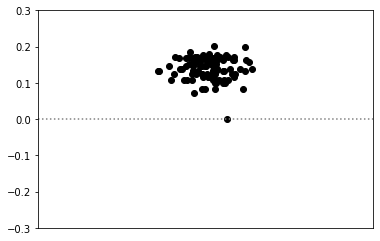

In [8]:
_plt.scatter(_N.random.randn(100)*0.05, scrs, color="black")
_plt.xlim(-0.4, 0.4)
_plt.ylim(-0.3, 0.3)
_plt.axhline(y=0, ls=":", color="grey")
_plt.xticks([])
